# Тестирование на нормальном распределении

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../metric')
sys.path.append('../util')

import nn
import metrics
import loss

In [2]:
count = 500
sigma = 2.0
n = 2
k = 50

xs1 = np.random.normal(0, sigma, (count, 2))
ys1 = np.full(count, 0)

xs2 = np.random.normal(3, sigma, (count, 2))
ys2 = np.full(count, 1)

In [3]:
xs = np.concatenate((xs1, xs2))
ys = np.concatenate((ys1, ys2))

perm = np.random.permutation(2 * count)
xs = xs[perm, :]
ys = ys[perm]

train_set_len = int(2 * count * 0.8)
train_set_xs = xs[:train_set_len, :]
train_set_ys = ys[:train_set_len]
valid_set_xs = xs[train_set_len:, :]
valid_set_ys = ys[train_set_len:]

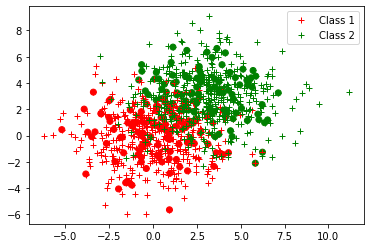

In [4]:
color = ['r', 'g']
classes = np.zeros(n * count - train_set_len, dtype=np.int)
for i in range(0, n * count - train_set_len):
    cls, results = nn.knn(n, k,
                          train_set_xs, train_set_ys,
                          valid_set_xs[i, :],
                          metrics.euclidean)
    classes[i] = cls

plt.plot(xs1[:, 0], xs1[:, 1], 'r+', label='Class 1')
plt.plot(xs2[:, 0], xs2[:, 1], 'g+', label='Class 2')

plt.scatter(valid_set_xs[:, 0],
            valid_set_xs[:, 1],
            c=[color[cls] for cls in classes])

plt.legend()

In [5]:
loss.empirical_risk_cls(classes, valid_set_ys)

0.18